GPT-1 모델의 구조는 Transformer의 decoder만 사용하기에 아래와 같은 변경사항이 필요하다.

#### Pre-training dataset
- 기존 chat dataset은 Question과 Answer로 나눠져 있으며, pairs의 형태로 구성하여 encoder와 decoder의 input을 정의했다.
- GPT-1의 pre-training 과정에서 이러한 구조는 불필요하기에 Question과 Answer를 하나로 합쳐 pre-training dataset을 구축했다.

#### Positional Encoding
- positional encoding으로 sin, cos함수를 활용하는 방식 대신에 학습 가능한 파라미터로 선정했다.
- 이는 nn.Embedding() 함수를 통해 손쉽게 구현할 수 있다.
- 위치 인덱스 값으로 이루어진 sequence를 입력으로 받아, 위치 별로 embedding을 학습하고, lookup tabel을 통해 positional embedding 벡터를 가져온다. 

#### Encoder-Decoder Attention
- 기존 Transformer는 encoder와 decoder 간의 cross attention을 수행하였지만, GPT-1에서는 해당 연산을 삭제해야 한다.
- Encoder-Decoder Attention을 삭제하였으며 Masked Self-attention 이후, 바로 Feed-Forwad layer가 오도록 위치시켰다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
chat_df = pd.read_csv('~/work/transformer_chatbot/data/ChatbotData.csv')
chat_df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
question = chat_df['Q'].copy()
answer = chat_df['A'].copy()
data = pd.concat([question, answer])

In [4]:
data.reset_index(drop=True, inplace=True)

## 데이터 전처리

In [6]:
import re 
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence 양쪽 공백을 제거
  sentence = sentence.strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, 슛자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [7]:
from tqdm import tqdm

for i in tqdm(range(len(data))):

    data.loc[i] = preprocess_sentence(data.loc[i])


data.drop_duplicates(inplace=True)
data = data.replace('', pd.NA)
data = data.dropna(how = 'any')
data.reset_index(drop=True, inplace=True)

100%|██████████| 23646/23646 [00:00<00:00, 25360.02it/s]


문장의 최단 길이: 1
문장의 최장 길이: 78
문장의 평균 길이: 14


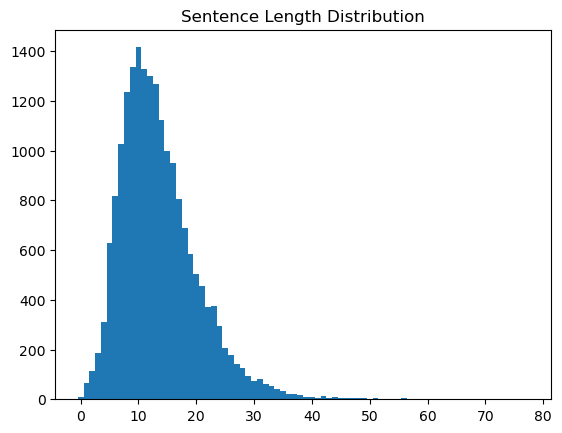

In [8]:
import matplotlib.pyplot as plt
min_len = 999
max_len = 0
sum_len = 0

for sen in data:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data))

sentence_length = np.zeros((max_len), dtype=int)

for sen in data:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [9]:
def check_sentence_with_length(raw, length):
    count = 0

    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

print( '길이가 1인 text 확인')
print('===Q====')
check_sentence_with_length(data, 1)

print('===A===')
check_sentence_with_length(data, 1)

길이가 1인 text 확인
===Q====
야
음
응
헉
왜
후
휴
흠
네
===A===
야
음
응
헉
왜
후
휴
흠
네


In [10]:
check_sentence_with_length(data, 78)

연애는 문제가 있으면 문제를 해결 하기 위해 함께 노력하고 그 속에서 더욱 단단해지는 과정인데 , 그 과정을 못 참고 피하기만 했나봅니다 .


In [11]:
# 1이하 길이의 text 삭제
data = data[data.str.len() > 1]


print('전처리 후 길이가 1이하인 Text: ', check_sentence_with_length(data, 1))

전처리 후 길이가 1이하인 Text:  None


### Tokenizer SentencePiece 모델 학습

In [12]:
corpus_file = "clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for sen in data:
        f.write(sen + "\n")


In [13]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="spm_ko_chat",
    vocab_size=10000,
    character_coverage=1.0,
    model_type="bpe",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus.txt
  input_format: 
  model_prefix: spm_ko_chat
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  diffe

In [14]:
sp = spm.SentencePieceProcessor()
sp.Load("spm_ko_chat.model")

# 예제 문장
sentence = "나는 점심을 10분전에 먹어서 매우 졸려.."

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)

전처리 후의 문장: 나는 점심을 10분전에 먹어서 매우 졸려 . .
Tokenized: ['▁나는', '▁점심', '을', '▁10', '분', '전에', '▁먹어서', '▁매', '우', '▁졸려', '▁.', '▁.']
Encoded: [580, 1555, 8798, 1276, 8912, 2161, 8659, 339, 8913, 1819, 4, 4]
Decoded: 나는 점심을 10분전에 먹어서 매우 졸려 . .


In [15]:
sen_list = []

for sen in data:
    # 1) 토크나이즈
    sen_ids = sp.EncodeAsIds(sen)
    sen_list.append(sen_ids)


total_data_text = list(sen_list)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)


# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  5.424423393739703
문장길이 최대 :  27
문장길이 표준편차 :  2.3868877198414324
pad_sequences maxlen :  10
전체 문장의 0.9667421746293245%가 maxlen 설정값 이내에 포함됩니다. 


## 데이터 셋 구성

In [21]:
class KoChatDataset(Dataset):
    def __init__(self, data, sp, max_length=11):
        super().__init__()
        self.sp = sp
        self.max_length = max_length+1
        self.data = []

        for sen in data:
            # 1) 토크나이즈
            sen_ids = sp.EncodeAsIds(sen)


            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            sen_tokens = [bos_id] + sen_ids + [eos_id]


            # 3) 길이 제한
            if len(sen_tokens) > (self.max_length):
                continue

            # 4) 고정 길이 패딩
            sen_tokens += [0]*(self.max_length - len(sen_tokens))  # 0 -> <pad> 가정


            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = sen_tokens[:-1]
            target = sen_tokens[1:]

            self.data.append({
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return dec_input, target

In [17]:
data = data.values

In [22]:
import random

random.seed(1)

random.shuffle(data)

n_of_val = int(len(data)*0.2)

train_data = data[:-n_of_val]
val_data = data[-n_of_val:]

print('train sample 수: ', len(train_data))
print('val sample 수: ', len(val_data))

train sample 수:  15540
val sample 수:  3884


In [23]:
train_dataset = KoChatDataset(train_data, sp, max_length=11)
val_dataset = KoChatDataset(val_data, sp, max_length=11)

for decoder_input, decoder_label  in train_dataset:

    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

tensor([   1,  206, 2787,  606,   52,    4,    2,    0,    0,    0,    0])
시간이 무색해지네요 .
tensor([ 206, 2787,  606,   52,    4,    2,    0,    0,    0,    0,    0])
시간이 무색해지네요 .


In [24]:
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=32,shuffle=False)

for decoder_input, decoder_label in train_dataloader:
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 11])
torch.Size([32, 11])


## 모델 정의

### Multi-Head Attention

In [25]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output

### Masking

### paddig mask

In [26]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

### Look-ahead mask

In [27]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

### Decoder

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # encoder-decoder attention layer 삭제
        
        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)


    def forward(self, x, look_ahead_mask=None): # encoder_output 입력 삭제
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # masked self-attention 이후 피드포워드
        
        # 2) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out)
        out2 = self.norm2(out1 + ffn_out)  # 잔차 연결 + LayerNorm

        return out2

In [58]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 max_seq_len,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # learnable parameter로 positional encoding 정의
        self.pos_encoding = nn.Embedding(max_seq_len, d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, look_ahead_mask=None): # encoder의 padding 위치를 불러오던 padding_mask 삭제
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x_emb = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 
        # 0 ~ seqence length의 index tensor 생성 후, 
        # embedding과 더해주는 과정에서 broadcasting을 위해 차원 수 늘려줌
        x_pos = torch.arange(x.size(-1), device=x.device).unsqueeze(0) 
        x_pos = self.pos_encoding(x_pos)    
        x = x_emb + x_pos  # (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, look_ahead_mask)

        return x

### Transformer

In [59]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 max_seq_len,     # positional embedding을 위한 sequence 최대 길이
                 dropout=0.1):
        super(Transformer, self).__init__()


        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            max_seq_len=max_seq_len,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, dec_inputs): # decoder 입력
        # 인코더 과정 삭제
        
        # 1) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 2) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            look_ahead_mask=look_ahead_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 3) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [60]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 4     # 디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.3      # 드롭아웃 비율
VOCAB_SIZE = 10000 # 단어 집합 크기(예시)
MAX_LEN = 11       # sequence 최대 길이

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    max_seq_len=MAX_LEN,
    dropout=DROPOUT
)

print(model)

Transformer(
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (pos_encoding): Embedding(11, 256)
    (dropout): Dropout(p=0.3, inplace=False)
    (dec_layers): ModuleList(
      (0-3): 4 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, i

In [61]:
from torchinfo import summary
summary(model, input_size=(16,11), dtypes=[torch.long]) #

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [16, 11, 10000]           --
├─Decoder: 1-1                                [16, 11, 256]             --
│    └─Embedding: 2-1                         [16, 11, 256]             2,560,000
│    └─Embedding: 2-2                         [1, 11, 256]              2,816
│    └─Dropout: 2-3                           [16, 11, 256]             --
│    └─ModuleList: 2-4                        --                        --
│    │    └─DecoderLayer: 3-1                 [16, 11, 256]             527,104
│    │    └─DecoderLayer: 3-2                 [16, 11, 256]             527,104
│    │    └─DecoderLayer: 3-3                 [16, 11, 256]             527,104
│    │    └─DecoderLayer: 3-4                 [16, 11, 256]             527,104
├─Linear: 1-2                                 [16, 11, 10000]           2,570,000
Total params: 7,241,232
Trainable params: 7,241,232
Non-tr

## 모델 학습

In [62]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

In [63]:
# label smoothing 추가
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id(), label_smoothing=0.1)

# Optimizer 정의
optimizer = optim.Adam(model.parameters(),lr= 1.0, betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [64]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    dec_input, target = [x.to(device) for x in batch]
    
    optimizer.zero_grad()

    # 모델 포워드 패스
    # decoder 입력만 모델에 들어감
    logits = model(dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    logits = logits.view(-1, logits.shape[-1])
    target = target.view(-1)
    loss = loss_function(logits, target)
    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [65]:
def train(model, train_dataloader, val_dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)
    patience = 50
    best_val_loss = float('inf')
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(train_dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(train_dataloader)
        avg_acc = total_acc / len(train_dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Train Loss: {avg_loss:.4f}, Avg Train Acc: {avg_acc:.4f}")
        
        train_loss_list.append(avg_loss)
        train_acc_list.append(avg_acc)
        
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for step, batch in enumerate(val_dataloader):
                dec_input, target = [x.to(device) for x in batch]

                logits = model(dec_input)  # (batch_size, seq_len, vocab_size)

                # Loss 계산 (패딩 토큰 무시)
                logits = logits.view(-1, logits.shape[-1])
                target = target.view(-1)
                loss = loss_function(logits, target)

                val_loss += loss.item()
                val_acc += accuracy_function(logits, target, pad_id=sp.pad_id())

            val_avg_loss = val_loss / len(val_dataloader)
            val_avg_acc = val_acc / len(val_dataloader)
            print(f"Epoch {epoch+1} Completed - Avg Val Loss: {val_avg_loss:.4f}, Avg Val Acc: {val_avg_acc:.4f}")

            val_loss_list.append(val_avg_loss)
            val_acc_list.append(val_avg_acc)

            # Early Stopping 조건
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [66]:
%%time

train_loss_list, train_acc_list, val_loss_list, val_acc_list = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=100,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.3356, Acc: 0.0000
[Epoch 1, Step 100] Loss: 8.3027, Acc: 0.1749
[Epoch 1, Step 200] Loss: 7.7894, Acc: 0.1624
[Epoch 1, Step 300] Loss: 7.3922, Acc: 0.1627
[Epoch 1, Step 400] Loss: 7.0259, Acc: 0.1856
Epoch 1 Completed - Avg Train Loss: 7.7762, Avg Train Acc: 0.1492
Epoch 1 Completed - Avg Val Loss: 7.0399, Avg Val Acc: 0.1909
[Epoch 2, Step 0] Loss: 6.8592, Acc: 0.1703
[Epoch 2, Step 100] Loss: 6.9823, Acc: 0.1836
[Epoch 2, Step 200] Loss: 7.0156, Acc: 0.1574
[Epoch 2, Step 300] Loss: 6.9513, Acc: 0.1802
[Epoch 2, Step 400] Loss: 7.0390, Acc: 0.1716
Epoch 2 Completed - Avg Train Loss: 6.9080, Avg Train Acc: 0.1932
Epoch 2 Completed - Avg Val Loss: 6.8442, Avg Val Acc: 0.2086
[Epoch 3, Step 0] Loss: 6.5561, Acc: 0.2010
[Epoch 3, Step 100] Loss: 6.7320, Acc: 0.2211
[Epoch 3, Step 200] Loss: 6.6889, Acc: 0.2118
[Epoch 3, Step 300] Loss: 6.7250, Acc: 0.2123
[Epoch 3, Step 400] Loss: 6.8030, Acc: 0.2042
Epoch 3 Completed - Avg Train Loss: 6.6917, Avg Train Acc: 0

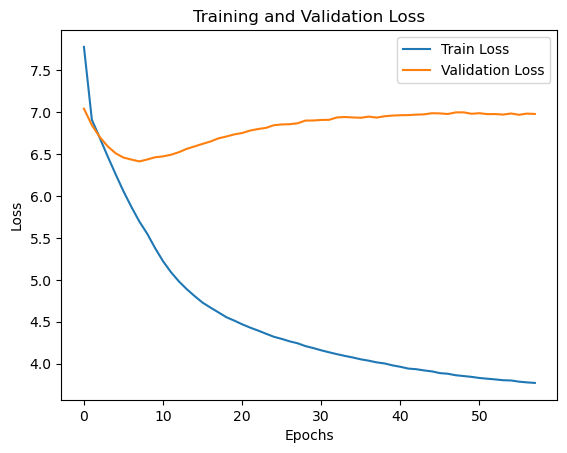

In [67]:
plt.plot(range(len(train_loss_list)), train_loss_list, label='Train Loss')
plt.plot(range(len(val_loss_list)), val_loss_list, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

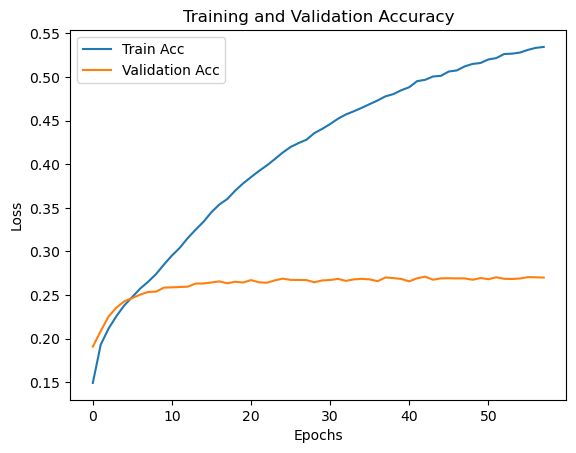

In [68]:
train_acc_list = [train_acc.cpu() for train_acc in train_acc_list]
val_acc_list = [val_acc.cpu() for val_acc in val_acc_list]

plt.plot(range(len(train_acc_list)), train_acc_list, label='Train Acc')
plt.plot(range(len(val_acc_list)), val_acc_list, label='Validation Acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Accuracy")
plt.show()

In [69]:
def decoder_inference(model, sentence, max_len, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    
    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 
    dec_input_ids = [START_TOKEN] + tokenizer.encode(sentence)

    # 입력 최대 길이에서 start token과 입력 sentence의 길이를 뺀 만큼 text 생성
    GEN_MAX_LENGTH = max_len - len(dec_input_ids)
    
    # 차원 확장: (batch_size=1, seq_len)
    dec_input = torch.tensor([dec_input_ids], dtype=torch.long, device=device)
    

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(GEN_MAX_LENGTH):
            # 모델 forward: (dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [70]:
def sentence_generation(model, sentence, max_len, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, max_len, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [79]:
print('============================')
sentence = '속이 좀 안 좋아서 병원을 '
sentence_generation(model, sentence, 11, sp, device)

입력 : 속이 좀 안 좋아서 병원을 
출력 : 속이 좀 안 좋아서 병원을 수 있어요 .


'속이 좀 안 좋아서 병원을 수 있어요 .'